<a href="https://colab.research.google.com/github/VarunSUK/ml-scd-detection/blob/main/Preprocessing_and_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧼 Preprocessing & Augmentation: Sickle Cell Image Dataset

### 📘 Notebook: `02_Preprocessing_and_Augmentation.ipynb`

---

## 📌 Objective

Prepare the dataset for training a convolutional neural network by:

- Loading image data from directories
- Applying preprocessing (resizing, normalization)
- Applying data augmentation to reduce overfitting
- Splitting into training, validation, and test sets
- Organizing datasets using TensorFlow’s `image_dataset_from_directory`

---

## 🗂️ Dataset Structure Recap

```
Data/
├── Positive/
│   ├── Labelled/
│   └── Unlabelled/
└── Negative/
    └── Clear/
```

We'll combine both `Positive/Labelled` and `Positive/Unlabelled` as the **positive class**, and `Negative/Clear` as the **negative class**.

---

## 🧠 Why Preprocessing Matters

Preprocessing ensures all images are in the same format and scale, which is essential for efficient and stable training of neural networks. Augmentation helps improve generalization on unseen data.

---


In [ ]:
import tensorflow as tf

In [ ]:
import os
import shutil
import random

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
project_path = "/content/drive/MyDrive/Colab Notebooks/Sickle Cell Project"
data_path = os.path.join(project_path, "Data")
positive_labelled = os.path.join(data_path, "Positive", "Labelled")
positive_unlabelled = os.path.join(data_path, "Positive", "Unlabelled")
negative_clear = os.path.join(data_path, "Negative", "Clear")

target_base = os.path.join(project_path, "Dataset")
os.makedirs(target_base, exist_ok=True)

# Train/val/test split ratios
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Copy helper
def split_and_copy_images(image_paths, label, target_dir):
    random.shuffle(image_paths)
    n_total = len(image_paths)
    n_train = int(n_total * train_split)
    n_val = int(n_total * val_split)

    split_sets = {
        'train': image_paths[:n_train],
        'val': image_paths[n_train:n_train+n_val],
        'test': image_paths[n_train+n_val:]
    }

    for split, paths in split_sets.items():
        split_path = os.path.join(target_dir, split, label)
        os.makedirs(split_path, exist_ok=True)
        for img_path in paths:
            shutil.copy(img_path, os.path.join(split_path, os.path.basename(img_path)))

# Load all image paths
positive_images = []
for folder in [positive_labelled, positive_unlabelled]:
    positive_images += [os.path.join(folder, f)
                        for f in os.listdir(folder)
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

negative_images = [os.path.join(negative_clear, f)
                   for f in os.listdir(negative_clear)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Split and copy into Dataset/train|val|test
split_and_copy_images(positive_images, 'Positive', target_base)
split_and_copy_images(negative_images, 'Negative', target_base)

print("✅ Dataset split completed and copied to Dataset/train, val, test.")


Mounted at /content/drive
✅ Dataset split completed and copied to Dataset/train, val, test.


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(target_base, 'train'),
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(target_base, 'val'),
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(target_base, 'test'),
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Found 590 files belonging to 2 classes.
Found 236 files belonging to 2 classes.
Found 242 files belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers

# Define preprocessing + augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

preprocessing = tf.keras.Sequential([
    layers.Rescaling(1./255)
])

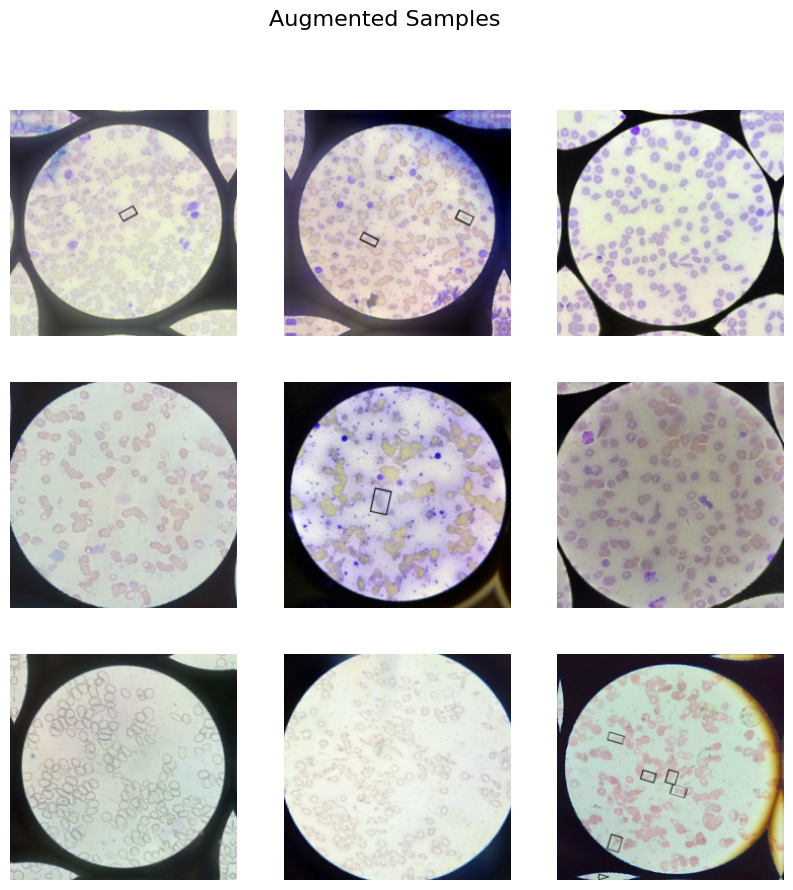

In [ ]:
import matplotlib.pyplot as plt

for images, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = data_augmentation(images)[i].numpy().astype("uint8")
        plt.imshow(aug_img)
        plt.axis("off")
    plt.suptitle("Augmented Samples", fontsize=16)
